In [ ]:
!ps aux | grep unzip

sagemak+ 23185  0.0  0.0   4792  3124 pts/0    Ss+  08:52   0:00 /bin/bash -c ps aux | grep unzip
sagemak+ 23189  0.0  0.0   4032  2028 pts/0    S+   08:52   0:00 grep unzip


In [ ]:
# Count images in train2017
!ls -1 coco/images/train2017/ | wc -l
# Expected: ~118,287 images

# Count images in val2017
!ls -1 coco/images/val2017/ | wc -l
# Expected: ~5,000 images

# Check annotations
!ls -lh coco/annotations/annotations/instances_train2017.json
!ls -lh coco/annotations/annotations/instances_val2017.json
# Expected: Files should exist, ~443MB and ~19MB respectively

118287
5000
-rw-rw-r-- 1 sagemaker-user users 449M Sep  1  2017 coco/annotations/annotations/instances_train2017.json
-rw-rw-r-- 1 sagemaker-user users 20M Sep  1  2017 coco/annotations/annotations/instances_val2017.json


In [ ]:
import json
from pathlib import Path
from collections import defaultdict

# Configuration
COCO_ROOT = Path("coco/images")

# Your target classes with official COCO IDs
TARGET_CLASSES = {
    "person": 1, "laptop": 73, "cell phone": 77, "keyboard": 76,
    "mouse": 74, "chair": 62, "book": 84, "tv": 72, "dining table": 67,
    "clock": 85, "bottle": 44, "cup": 47, "fork": 48, "knife": 49,
    "spoon": 50, "bowl": 51, "sandwich": 54, "pizza": 59, "banana": 52,
    "apple": 53, "couch": 63, "bed": 65, "remote": 75, "microwave": 78,
    "oven": 79, "refrigerator": 82, "sink": 81, "fire hydrant": 11,
    "scissors": 87, "handbag": 31, "suitcase": 33, "toilet": 70,
    "toothbrush": 90
}

# Your quotas for reference
CLASS_QUOTAS = {
    "person": 5000, "laptop": 2000, "cell phone": 1000, "chair": 800,
    "book": 700, "bottle": 600, "cup": 500, "tv": 400, "dining table": 350,
    "mouse": 300, "keyboard": 300, "sandwich": 250, "pizza": 200,
    "microwave": 150, "refrigerator": 150, "fork": 100, "knife": 100,
    "fire hydrant": 80, "toilet": 50, "oven": 50,
    "banana": 500, "bowl": 1000, "bed": 1000, "scissors": 1000,
    "clock": 500, "apple": 500
}

def load_coco_annotations(annotation_path):
    print(f"Loading {annotation_path}...")
    with open(annotation_path) as f:
        data = json.load(f)
    print(f"Loaded {len(data['images'])} images, {len(data['annotations'])} annotations")
    return data

def count_classes():
    # Load annotations
    train_ann = load_coco_annotations(COCO_ROOT.parent / "annotations/annotations/instances_train2017.json")
    val_ann = load_coco_annotations(COCO_ROOT.parent / "annotations/annotations/instances_val2017.json")

    # Combine data
    all_images = {img["id"]: img for img in train_ann["images"] + val_ann["images"]}
    all_annotations = train_ann["annotations"] + val_ann["annotations"]
    print(f"Combined: {len(all_images)} images, {len(all_annotations)} annotations")

    # Count images per class (unique image IDs)
    class_image_counts = defaultdict(set)
    for ann in all_annotations:
        coco_id = ann["category_id"]
        if coco_id in TARGET_CLASSES.values():
            class_name = next(k for k, v in TARGET_CLASSES.items() if v == coco_id)
            class_image_counts[class_name].add(ann["image_id"])

    # Count total instances per class (including multiple per image)
    class_instance_counts = defaultdict(int)
    for ann in all_annotations:
        coco_id = ann["category_id"]
        if coco_id in TARGET_CLASSES.values():
            class_name = next(k for k, v in TARGET_CLASSES.items() if v == coco_id)
            class_instance_counts[class_name] += 1

    # Print results
    print("\nImages per class (unique images containing the class):")
    for cls in sorted(TARGET_CLASSES.keys()):
        count = len(class_image_counts.get(cls, set()))
        quota = CLASS_QUOTAS.get(cls, "N/A")
        print(f"{cls:<15}: {count:>5} images (Quota: {quota})")

    print("\nTotal instances per class (all annotations):")
    for cls in sorted(TARGET_CLASSES.keys()):
        count = class_instance_counts.get(cls, 0)
        print(f"{cls:<15}: {count:>5} instances")

if __name__ == "__main__":
    count_classes()

Loading coco/annotations/annotations/instances_train2017.json...
Loaded 118287 images, 860001 annotations
Loading coco/annotations/annotations/instances_val2017.json...
Loaded 5000 images, 36781 annotations
Combined: 123287 images, 896782 annotations

Images per class (unique images containing the class):
apple          :  1662 images (Quota: 500)
banana         :  2346 images (Quota: 500)
bed            :  3831 images (Quota: 1000)
book           :  5562 images (Quota: 700)
bottle         :  8880 images (Quota: 600)
bowl           :  7425 images (Quota: 1000)
cell phone     :  5017 images (Quota: 1000)
chair          : 13354 images (Quota: 800)
clock          :  4863 images (Quota: 500)
couch          :  4618 images (Quota: N/A)
cup            :  9579 images (Quota: 500)
dining table   : 12338 images (Quota: 350)
fire hydrant   :  1797 images (Quota: 80)
fork           :  3710 images (Quota: 100)
handbag        :  7133 images (Quota: N/A)
keyboard       :  2221 images (Quota: 300)
kni

In [ ]:
import os
import json
import shutil
import yaml
import random
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

# Configuration
COCO_ROOT = Path("coco/images")
OUTPUT_DIR = Path("filtered_coco")

# Create directory structure
for split in ['train', 'val']:
    (OUTPUT_DIR / f"images/{split}").mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR / f"labels/{split}").mkdir(parents=True, exist_ok=True)

# Define target classes and quotas
TARGET_CLASSES = {
    "person": 1, "laptop": 73, "cell phone": 77, "keyboard": 76,
    "mouse": 74, "chair": 62, "book": 84, "tv": 72, "dining table": 67,
    "clock": 85, "bottle": 44, "cup": 47, "fork": 48, "knife": 49,
    "spoon": 50, "bowl": 51, "sandwich": 54, "pizza": 59, "banana": 52,
    "apple": 53, "couch": 63, "bed": 65, "remote": 75, "microwave": 78,
    "oven": 79, "refrigerator": 82, "sink": 81, "fire hydrant": 11,
    "scissors": 87, "handbag": 31, "suitcase": 33, "toilet": 70,
    "toothbrush": 90
}

CLASS_QUOTAS = {
    "person": 5000, "laptop": 2000, "cell phone": 1000, "chair": 800,
    "book": 700, "bottle": 600, "cup": 500, "tv": 400, "dining table": 350,
    "mouse": 300, "keyboard": 300, "sandwich": 250, "pizza": 200,
    "microwave": 150, "refrigerator": 150, "fork": 100, "knife": 100,
    "fire hydrant": 80, "toilet": 50, "oven": 50,
    "banana": 500, "bowl": 1000, "bed": 1000, "scissors": 1000,
    "clock": 500, "apple": 500
}

def load_coco_annotations(annotation_path):
    print(f"Loading {annotation_path}...")
    with open(annotation_path) as f:
        data = json.load(f)
    print(f"Loaded {len(data['images'])} images, {len(data['annotations'])} annotations")
    return data

def convert_to_yolo(bbox, img_width, img_height):
    x, y, w, h = bbox
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    return x_center, y_center, w_norm, h_norm

def filter_dataset():
    # Load annotations
    train_ann = load_coco_annotations(COCO_ROOT.parent / "annotations/annotations/instances_train2017.json")
    val_ann = load_coco_annotations(COCO_ROOT.parent / "annotations/annotations/instances_val2017.json")

    all_images = {img["id"]: img for img in train_ann["images"] + val_ann["images"]}
    all_annotations = train_ann["annotations"] + val_ann["annotations"]
    print(f"Combined: {len(all_images)} images, {len(all_annotations)} annotations")

    image_sources = {img["id"]: "train2017" for img in train_ann["images"]}
    image_sources.update({img["id"]: "val2017" for img in val_ann["images"]})

    class_image_pools = defaultdict(set)
    image_annotations = defaultdict(list)

    print("Processing annotations...")
    for ann in tqdm(all_annotations, desc="Annotations"):
        coco_id = ann["category_id"]
        if coco_id in TARGET_CLASSES.values():
            class_name = next(k for k, v in TARGET_CLASSES.items() if v == coco_id)
            class_image_pools[class_name].add(ann["image_id"])
            image_annotations[ann["image_id"]].append((coco_id, ann["bbox"]))

    print("\nSelecting images to meet quotas...")
    selected_images = set()
    class_counts = defaultdict(int)
    for class_name, quota in CLASS_QUOTAS.items():
        if class_name not in class_image_pools:
            print(f"⚠️ Class not found in dataset: {class_name}")
            continue
        available = len(class_image_pools[class_name])
        if available < quota:
            print(f"⚠️ Only {available} images available for {class_name} (requested {quota})")
        take = min(quota, available)
        images = list(class_image_pools[class_name])
        random.shuffle(images)
        for img_id in images[:take]:
            if img_id not in selected_images:
                selected_images.add(img_id)
                class_counts[class_name] += 1

    selected_images = list(selected_images)
    random.shuffle(selected_images)
    split_idx = int(0.9 * len(selected_images))
    train_ids = set(selected_images[:split_idx])

    print("\nSaving dataset...")
    for i, img_id in enumerate(tqdm(selected_images, desc="Images")):
        img_info = all_images[img_id]
        file_name = img_info["file_name"]
        source_split = image_sources[img_id]
        dest_split = "train" if img_id in train_ids else "val"

        src_img = COCO_ROOT / source_split / file_name
        dst_img = OUTPUT_DIR / f"images/{dest_split}" / file_name
        os.makedirs(dst_img.parent, exist_ok=True)
        try:
            shutil.copy(src_img, dst_img)
        except FileNotFoundError:
            print(f"Warning: Image not found: {src_img}, skipping...")
            continue

        label_file = OUTPUT_DIR / f"labels/{dest_split}" / f"{Path(file_name).stem}.txt"
        os.makedirs(label_file.parent, exist_ok=True)
        with open(label_file, "w") as f:
            for class_id, bbox in image_annotations[img_id]:
                yolo_id = list(TARGET_CLASSES.values()).index(class_id)
                x_center, y_center, w_norm, h_norm = convert_to_yolo(
                    bbox, img_info["width"], img_info["height"])
                f.write(f"{yolo_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

    # Create dataset.yaml
    yaml_content = {
        "path": str(OUTPUT_DIR.absolute()),
        "train": "images/train",
        "val": "images/val",
        "names": {i: cls for i, cls in enumerate(TARGET_CLASSES.keys())}
    }
    with open(OUTPUT_DIR / "dataset.yaml", "w") as f:
        yaml.dump(yaml_content, f, sort_keys=False)

    print("\n✅ Dataset created successfully!")
    print(f"Total images: {len(selected_images)} (Train: {split_idx}, Val: {len(selected_images) - split_idx})")
    print("\nFinal class counts:")
    for cls in sorted(CLASS_QUOTAS.keys(), key=lambda x: -CLASS_QUOTAS[x]):
        count = class_counts.get(cls, 0)
        quota = CLASS_QUOTAS[cls]
        print(f"{cls:<15}: {count:>5}/{quota:>5} ({min(100, count/quota*100):.1f}%)")

if __name__ == "__main__":
    filter_dataset()

Loading coco/annotations/annotations/instances_train2017.json...
Loaded 118287 images, 860001 annotations
Loading coco/annotations/annotations/instances_val2017.json...
Loaded 5000 images, 36781 annotations
Combined: 123287 images, 896782 annotations
Processing annotations...


Annotations: 100%|██████████| 896782/896782 [00:04<00:00, 203060.39it/s]



Selecting images to meet quotas...
⚠️ Only 975 images available for scissors (requested 1000)

Saving dataset...


Images: 100%|██████████| 15764/15764 [00:04<00:00, 3487.80it/s]



✅ Dataset created successfully!
Total images: 15764 (Train: 14187, Val: 1577)

Final class counts:
person         :  5000/ 5000 (100.0%)
laptop         :  1923/ 2000 (96.2%)
cell phone     :   864/ 1000 (86.4%)
bowl           :   838/ 1000 (83.8%)
bed            :   857/ 1000 (85.7%)
scissors       :   804/ 1000 (80.4%)
chair          :   714/  800 (89.2%)
book           :   592/  700 (84.6%)
bottle         :   532/  600 (88.7%)
cup            :   429/  500 (85.8%)
banana         :   455/  500 (91.0%)
clock          :   439/  500 (87.8%)
apple          :   390/  500 (78.0%)
tv             :   291/  400 (72.8%)
dining table   :   295/  350 (84.3%)
mouse          :   167/  300 (55.7%)
keyboard       :   179/  300 (59.7%)
sandwich       :   228/  250 (91.2%)
pizza          :   184/  200 (92.0%)
microwave      :   126/  150 (84.0%)
refrigerator   :   126/  150 (84.0%)
fork           :    86/  100 (86.0%)
knife          :    78/  100 (78.0%)
fire hydrant   :    77/   80 (96.2%)
toilet     

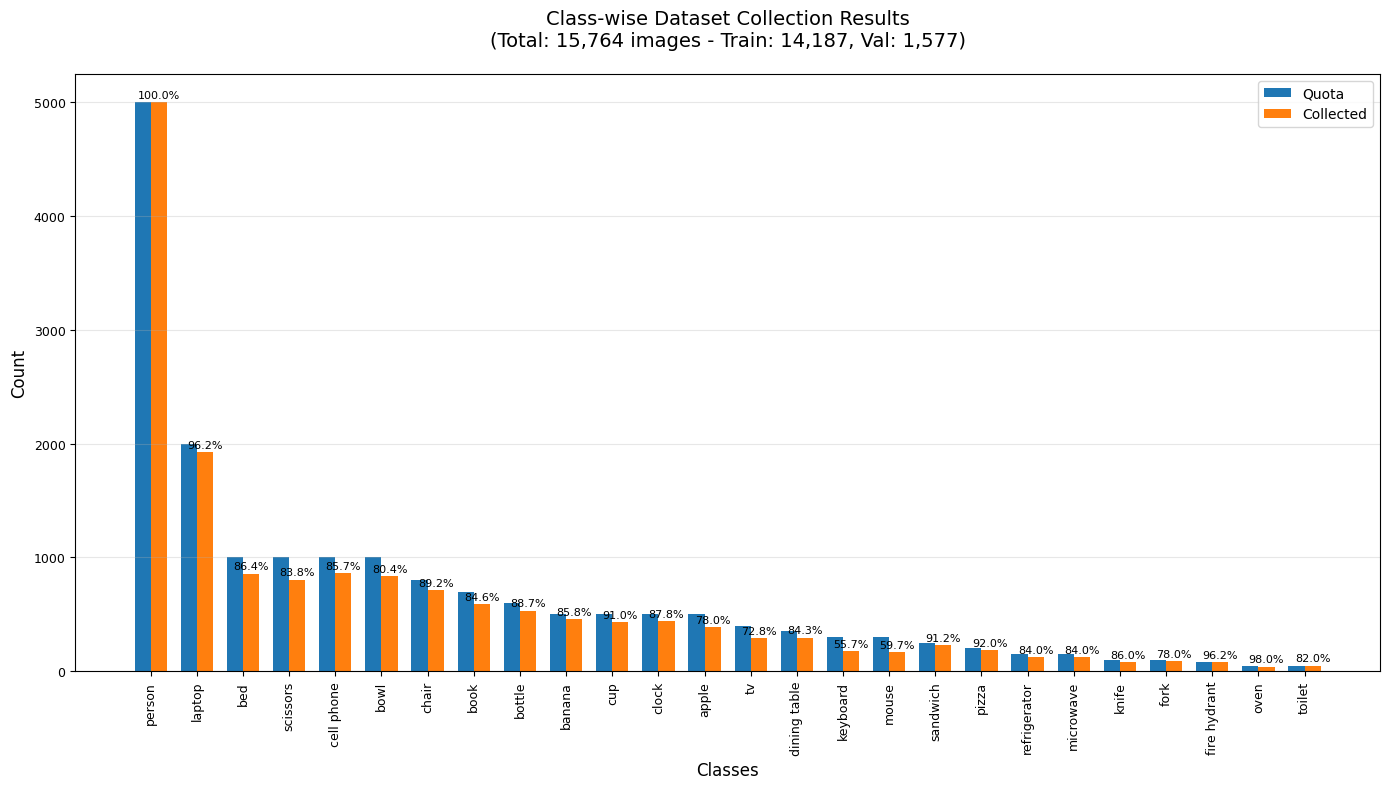

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = {
    "Class": [
        "person", "laptop", "cell phone", "bowl", "bed", "scissors",
        "chair", "book", "bottle", "cup", "banana", "clock", "apple",
        "tv", "dining table", "mouse", "keyboard", "sandwich",
        "pizza", "microwave", "refrigerator", "fork", "knife",
        "fire hydrant", "toilet", "oven"
    ],
    "Collected": [
        5000, 1923, 864, 838, 857, 804, 714, 592, 532, 429, 455, 439,
        390, 291, 295, 167, 179, 228, 184, 126, 126, 86, 78, 77, 49, 41
    ],
    "Quota": [
        5000, 2000, 1000, 1000, 1000, 1000, 800, 700, 600, 500, 500, 500,
        500, 400, 350, 300, 300, 250, 200, 150, 150, 100, 100, 80, 50, 50
    ],
    "Percentage": [
        100.0, 96.2, 86.4, 83.8, 85.7, 80.4, 89.2, 84.6, 88.7, 85.8,
        91.0, 87.8, 78.0, 72.8, 84.3, 55.7, 59.7, 91.2, 92.0, 84.0,
        84.0, 86.0, 78.0, 96.2, 98.0, 82.0
    ]
}

# Create figure
plt.figure(figsize=(14, 8))

# Sort data by quota (descending)
sorted_indices = np.argsort(data["Quota"])[::-1]
classes = np.array(data["Class"])[sorted_indices]
collected = np.array(data["Collected"])[sorted_indices]
quota = np.array(data["Quota"])[sorted_indices]
percentage = np.array(data["Percentage"])[sorted_indices]

# Create bars
x = np.arange(len(classes))
width = 0.35

bars1 = plt.bar(x - width/2, quota, width, label='Quota', color='#1f77b4')
bars2 = plt.bar(x + width/2, collected, width, label='Collected', color='#ff7f0e')

# Add percentage labels
for i, (rect, pct) in enumerate(zip(bars2, percentage[sorted_indices])):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2., height + 20,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

# Customize plot
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class-wise Dataset Collection Results\n(Total: 15,764 images - Train: 14,187, Val: 1,577)',
          fontsize=14, pad=20)
plt.xticks(x, classes, rotation=90, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(fontsize=10)

# Add grid
plt.grid(axis='y', alpha=0.3)

# Adjust layout
plt.tight_layout()

# Save and show
plt.savefig('class_quota_comparison.png', dpi=300, bbox_inches='tight')
plt.show()